In [1]:
# include the power socket setup, base classes and helpers
# (see PowerSocketSystem.py)
from PowerSocketSystem import *

## The Greedy Algorithm

Every time we plug into a socket we get a reward, in the form of an amount of charge, and every reward we get lets us calculate a more accurate estimate of a socket's true output. If we then just choose the socket with the highest estimate hopefully this will be the best socket and let us get charged up in the least amount of time.

When selecting the action with the highest value, the action chosen at time step 't', can be expressed by the formula:

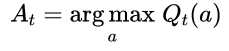

Where "argmax" specifies choosing the action 'a' for which Qₜ(a) is maximised.

When choosing the action with the highest estimated value, you are said to be "choosing greedily" and the actions with the maximum values, of which there may be more than one, are know as the "greedy actions".

All of this sounds like a reasonable way to select a good action, but there is one major flaw: the Greedy Algorithm wants to choose the action with the best estimate, yet provides no way to form these estimates. It purely exploits the information available, but does none of the exploration required to generate this information. 

Consequently, the greedy algorithm is initially selecting from actions that have not been tried and that have no estimate of their true value. Additionally, in the off chance that a good action is selected, there's no guarantee that this is the best action and, since the greedy algorithm will now have locked on to the chosen action, no other actions will ever be tried to confirm if the current one is the best or not. Therefore actions that could provide a higher long term return will be missed.

## The Optimistic-Greedy Algorithm

One very simple way to modify the Greedy Algorithm, to make it explore the set of available actions in search of the optimal action, is to set the initial action estimates to very high values.

In the power socket problem, if the action estimates are initialised to zero, as soon as one action is taken, assuming the socket returns even the smallest amount of charge, that action's mean reward will become greater than zero. As a result, in the eyes of the greedy algorithm, this action would then be better than all others and would therefore be the selected action forever more.

If instead the action estimates are initialised to a value that is higher than any of the possible socket outputs, when a socket is first tried, its mean reward decreases. It then has a value estimate lower than any of the others and is therefore not selected at the next time step. This results in every socket being tried in the first 'k' time steps (were 'k' is the number of sockets).

If we implement this algorithm we can see exactly what's going on:

In [2]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):    
                      
        # get the initial reqrd estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.) 
        
        # pass the true reward value to the base PowerSocket             
        super().__init__(q)         
        
        
    def initialize(self):        
        # estimate of this socket's reward value 
        # - set to supplied initial value
        self.Q = self.initial_estimate                  
        
        # the number of times this socket has been tried 
        # - set to 1 if an initialisation value is supplied
        self.n = 1 if self.initial_estimate  > 0 else 0        

So, in the code above, we derive a new OptimisticPowerSocket from the standard PowerSocket class we used before. The only difference is that now 'Q', the estimate of the socket's reward value, is initialised to a supplied initial estimate value and 'n', the number of times this socket has been tried, is set to 1 to take account of the initialisation.

If we initialise our socket estimates to a value slightly higher than the maximum possible reward value then this should encourage exploration in the early time steps, without taking too long to discover which socket produces the highest reward. 

Looking back at the Violin Plot of the reward distribution for each socket the highest output is approximately 16 seconds of charge. Therefore we've chosen a value of 20, which is slightly higher than the maximum possible reward, and initialised all socket estimates to this, as shown in the table below.

In [3]:
# highlight the maximum value on a row
def highlight_max_row_value( row ):
    '''
    highlight the maximum value on the supplied row
    '''
    is_max = row == row.max()            
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_change_in_column( col ):   
    '''
    highlight the entry before the column value changes
    '''    
    style = []
    for i in range(col.shape[0]):
        if i < (col.shape[0]-1) and col.iloc[i] != col.iloc[i+1]:
            style.append('background-color: yellow')
        else:
            style.append('')    
    return style

Test the optimistic socket over 30 time steps:

In [4]:
tester = SocketTester( OptimisticSocket, socket_order, initial_estimate = 20.)
tester.run( number_of_steps = 30 )

print(f'Mean Reward per Time Step = {tester.get_mean_reward()}')
print(f'Optimal Socket Selected = {tester.get_optimal_socket_percentage():0.3f}')
print(f'Socket Percentages = {tester.get_socket_percentages()}')

Mean Reward per Time Step = 10.923369265615902
Optimal Socket Selected = 0.667
Socket Percentages = [0.100 0.067 0.100 0.667 0.233]


In [6]:
# convert to a Pandas dataframe for table display & rename the columns to be 1-based
estimates = tester.socket_stats[:,:,0]
df = pd.DataFrame(estimates[:21])
df.columns = [1,2,3,4,5]

# show the estimates of each socket, highlighting the socket that has been selected for each time step
# - truncating to the first 20 time steps for clarity
df.style.apply(highlight_change_in_column).apply(highlight_max_row_value,axis=1,subset=df.index[-1])

,1,2,3,4,5
0,20,20,20,20,20
1,20,20,13.5297,20,20
2,20,20,13.5297,20,16.1927
3,20,11.9774,13.5297,20,16.1927
4,12.7532,11.9774,13.5297,20,16.1927
5,12.7532,11.9774,13.5297,16.7714,16.1927
6,12.7532,11.9774,13.5297,15.0812,16.1927
7,12.7532,11.9774,13.5297,15.0812,14.2069
8,12.7532,11.9774,13.5297,14.0907,14.2069
9,12.7532,11.9774,13.5297,14.0907,13.6125


Table 1 shows the reward estimates for each of the 5 sockets taken over 20 time steps. The yellow highlighted cells show the socket that has been selected at each time step. The points to note from this are:

* Initially all sockets have their estimates set to a value of 20.

* At each time step sockets are chosen using the Greedy algorithm, so the socket with the current maximum estimate is selected. When more than one socket has the maximum value, one of these is selected at random. This can be seen to occur over the first four time steps (0–3). 

* At time step 4 only one socket remains untested (socket 4). Since it still has its initial estimate of 20, it has the highest estimate out of all the sockets and is therefore chosen as the greedy action.

* As a result of the initialisation each of the 5 sockets is tried once during the first 5 time steps. This generalises to the standard Bandit problem, in which the 'k' actions will each be tried once during the first 'k' time steps.

* Over the next few time steps (5–13) it can be seen that various sockets are tried. This is the exploration stage of the process as the algorithm searches for the socket with the highest reward (the optimal action to take).

* From time step 14 onward, the algorithm has locked onto socket 4. This is the exploitation stage, during which the optimal action has been discovered and only this action will be taken going forward.

The same results are shown in the graph below. It can be seen how the estimated rewards, for each of the sockets, starts at the initial value of 20 and then decreases over time. Once the estimates of the non-optimal sockets have fallen below the true value of the optimal socket (shown as the black line of the graph) then they will not be tried again. After this has happened for all but the optimal socket only it will be selected and only its estimate will converge towards the true value. The reward estimates for the non-optimal actions will never converge to their true reward.

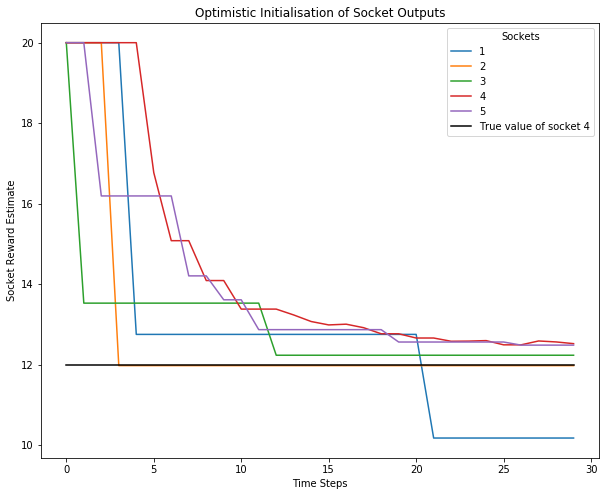

In [7]:
plt.figure(figsize=(10,8))

for socket in range(estimates.shape[1]):
    plt.plot(estimates[:30,socket], label = f'{socket+1}')       

plt.plot(np.ones(30)*np.max(socket_means),'k', label = f'True value of socket 4')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation of Socket Outputs')
plt.xlabel('Time Steps')
plt.ylabel('Socket Reward Estimate')

plt.savefig("optimistic_initialisation.png")

From the graph above it can be seen that the Optimistic Greedy algorithm works pretty well. It doesn't take too long for the sub-optimal actions to be discarded and for the focus to turn to the optimal action, which is the action we want to take if we're to get the maximum amount of charge in the shortest amount of time.

However, there are a couple of problems with our experiment:

* Firstly, we cheated! We chose the initial socket estimate of 20 based on our knowledge of the socket outputs. In the real world, and in Baby Robot's case, we don't have this knowledge.

* Secondly, we weren't very good at cheating! We chose the value of 20 because it was slightly higher than the highest output we obtained when looking at the socket outputs (see socket 4's output in the violin-plot above). However, it turns out that this isn't the best value. 

Take a look at the plots below, showing the mean total reward and the socket selection percentages, obtained over 30 time steps for a range of initial values.

In [8]:
def plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(10,8) ):

    plt.figure(figsize=figsize)
    plt.plot( initial_values, reward, marker='o', linestyle='--', color='r') 

    # draw reference lines
    plt.plot(np.ones(max_initial_value+1)*np.max(socket_means),'k', label = f'Maximum Socket Reward')
    plt.plot(np.ones(max_initial_value+1)*np.mean(socket_means),'b', label = f'Mean Socket Reward')

    plt.legend(title = 'Key:')
    plt.title('Optimistic Initialisation: Mean Total Reward vs Initial Values')
    plt.xlabel('Initial Values')
    plt.ylabel('Mean Total Reward')

    plt.savefig(f"mean_total_reward_v_initial_values_{max_initial_value}.png")

In [9]:
def run_initialisation_experiment( start, end, step = 1 ):    
    """ test varying the initial estimate for optimistic-greedy """
            
    number_of_tests = 1000
    number_of_steps = 30
    number_of_sockets = len(socket_order)    
    
    reward = []
    optimal_selected = []
    socket_percentages = []
    initial_values = []
        
    # iterate over the initial estimate values
    for initial_estimate in tqdm(range( start, (end+step), step )):
        
        initial_values.append( initial_estimate )

        socket_tester = SocketTester( OptimisticSocket, socket_order, initial_estimate = initial_estimate)

        socket_experiment = SocketExperiment(socket_tester = socket_tester,
                                             number_of_tests = number_of_tests,
                                             number_of_steps = number_of_steps)
        socket_experiment.run()
        
        reward.append( socket_experiment.get_reward_per_timestep() )
        optimal_selected.append( socket_experiment.get_optimal_selected() )
        socket_percentages.append( socket_experiment.get_socket_percentages() )                
     
    return initial_values, reward, optimal_selected, socket_percentages         

100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


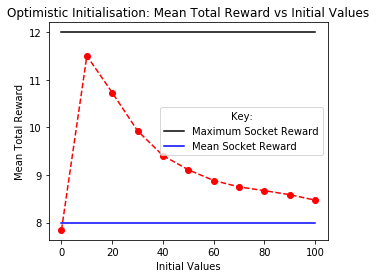

In [10]:
max_initial_value = 100   
step = 10
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )    
plot_initial_optimisation( initial_values, reward, max_initial_value, figsize=(5,4) )

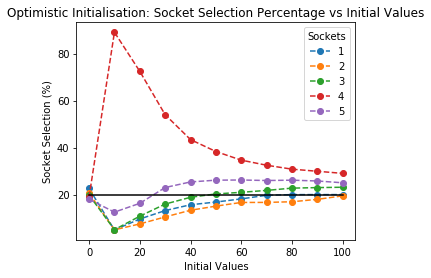

In [11]:
df = pd.DataFrame(socket_percentages)

plt.figure(figsize=(5,4))

for socket in range(df.shape[1]):
    plt.plot(initial_values, df[socket]*100, label = f'{socket+1}', marker='o', linestyle='--')           

plt.plot(initial_values, np.ones(df.shape[0])*20,'k')

plt.legend(title = 'Sockets')
plt.title('Optimistic Initialisation: Socket Selection Percentage vs Initial Values')
plt.xlabel('Initial Values')
plt.ylabel('Socket Selection (%)')

plt.savefig("optimistic_initialisation_percentages.png")

In the plots above, there are a few points of note:

* When the initial socket values are set to zero the mean total reward has a value of approximately 8. In this case the pure Greedy Algorithm is being implemented. There is no exploration, only exploitation, so sockets will be chosen randomly. In our case the mean socket outputs are 4, 6, 8, 10 and 12, so the mean socket reward is 8. This can also be seen in the graph of socket selection percentages. With a initialisation value of zero, all sockets are chosen with equal probability and, since there are 5 sockets, each is chosen with a 20% probability.

* Similarly, with very large initial values, the mean total reward starts to decrease to towards a value of 8, marking the point at which all sockets have been selected with an equal probability. In this case the reward returned from each socket is much smaller than the chosen initial value. It therefore takes much longer for the estimated reward to fall to a value close to the true maximum reward. During this time each socket will have approximately equal over-estimations of the true reward.

* The maximum mean total reward doesn't occur with an initialisation value of 20. Instead, as shown below, it actually occurs when the initial estimates are set to 11. This can also be seen in the graph of selection probability above in which, for an initial value of 11, the probability of selecting the optimal socket increases to a maximum value, while at the same time decreasing to a minimum for all other sockets. Since this initialisation value is greater than all but the optimal socket reward, as soon as the optimal socket is selected its estimated reward will be set higher than all others and so it will then be greedily chosen for all the remaining time steps. So the optimal socket only needs to be tested once to make it the greedy action.

100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


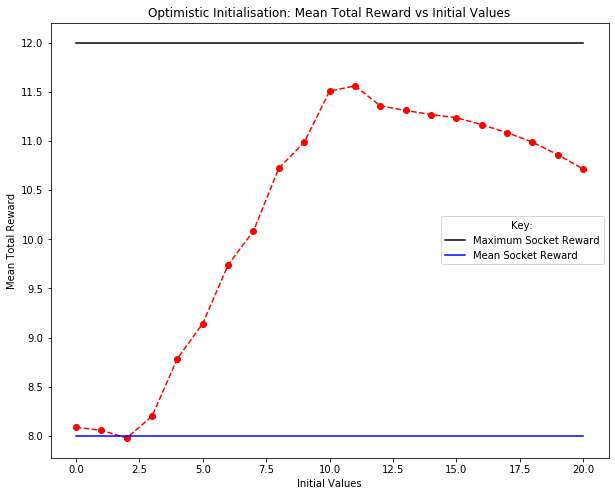

In [12]:
max_initial_value = 20   
step = 1
initial_values, reward, optimal_selected, socket_percentages = run_initialisation_experiment( 0, max_initial_value, step )    
plot_initial_optimisation( initial_values, reward, max_initial_value )

The Optimistic-Greedy algorithm is a simple way to encourage exploration during the early stages of testing. Initially all actions will be tried and, if a suitable initialisation value is used, the algorithm will quickly discard non-optimal actions and focus on the best actions. However, as shown above, a poorly chosen initial value can result in sub-optimal total return and, without some prior knowledge of the range of possible rewards, it can be hard to select the best initial values.

Another major drawback is the fact that exploration is confined to the initial time steps, restricting its use to stationary problems, in which the rewards for each action never change. It is not suitable for non-stationary situations, where the action rewards can change with time, due to the lack of ongoing exploration.